# Week 4: Clustering
[Jacob Page](jacob-page.com)

In this workshop we will work through a set of problems dissimilarity-based clustering. 

We will first generate some artificial data, building our own K-means algorithm and exploring the impact of feature engineering on the output clusters. We will then use the algorithms we built to attempt to find clusters in a "gene expression" dataset, before applying some hierarchical techniques. 

---


As you work through the problems it will help to refer to your lecture notes. The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 

You should regard exercises 1 - 7 as essential; the later exercises will help reinforce the topics introduced last week. 

# Imports
We will start with some simple artificial data and so will not initially need anything more complex than standard numpy and matplotlib (we'll add others later):

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1
We will work initially with some synthetic two-dimensional data generated from three normal distributions $N(\mathbf m, \sigma^2 \mathbf I)$. 

* Generate 500 samples normally distributed about a mean $\begin{pmatrix} 0 \\ 4 \end{pmatrix}$ with standard deviation $\sigma = 2$
* Generate 250 samples normally distributed about a mean $\begin{pmatrix} 0 \\ -4 \end{pmatrix}$ with standard deviation $\sigma = 1$
* Generate 100 samples normally distributed about a mean $\begin{pmatrix} -4 \\ 0 \end{pmatrix}$ with standard deviation $\sigma = 0.5$

Visualise your data in the plane.

In [2]:
n_cl_1 = 500
n_cl_2 = 250
n_cl_3 = 100

mean_cl_1 = np.array([0., 4.])
mean_cl_2 = np.array([0., -4.])
mean_cl_3 = np.array([-4., 0.])

sd_1 = 2.
sd_2 = 1.
sd_3 = 0.5

X = []
for j in range(n_cl_1):
  X.append(sd_1 * np.random.randn(2) + mean_cl_1)
for j in range(n_cl_2):
  X.append(sd_2 * np.random.randn(2) + mean_cl_2)
for j in range(n_cl_3): 
  X.append(sd_3 * np.random.randn(2) + mean_cl_3)
Xar = np.array(X)

In [3]:
np.random.shuffle(Xar)

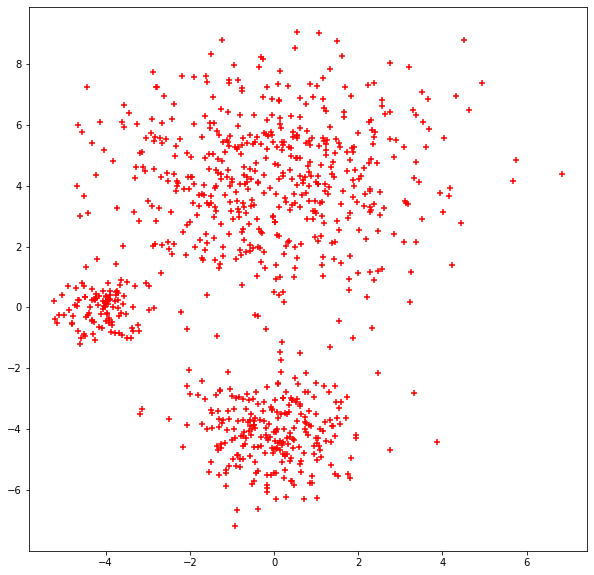

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(Xar[:,0], Xar[:,1], c='r', marker='+')

# Exercise 2
Write a function to compute a Euclidean dissimilarity for arbitrary dimension vectors. We will use it in this two-dimension example and then deploy it on a more complex problem.

This might seem a little excessive because the function is very simple -- however, makings things modular in this way will allow you to update your work in future with other dissimilarity measures, while retaining full control/understanding of the approach.

In [5]:
import scipy.linalg as la 

def dissim_square_euc(x_1, x_2):
  dist = la.norm(x_1 - x_2)
  return dist ** 2

# Exercise 3
Write a function that takes a data matrix X and a number of clusters K and returns K random vectors from X. We will use this to initialise our "mean" vectors.

Test your function by re-plotting your original data with some random choices of $\{\mathbf m_k^0\}$ overlayed. 

In [6]:
def initialise_mean_vectors_random(X_data, K):
  """ Return n_means initial "mean" vectors for K-means initialisation.
      These are just random rows from the original dataset X_array """
  random_indices = []
  while len(random_indices) < K:
    candidate_int = np.random.randint(X_data.shape[0])
    if candidate_int not in random_indices:
      random_indices.append(candidate_int)
                          
  mean_vectors = X_data[random_indices, :]
  return mean_vectors 

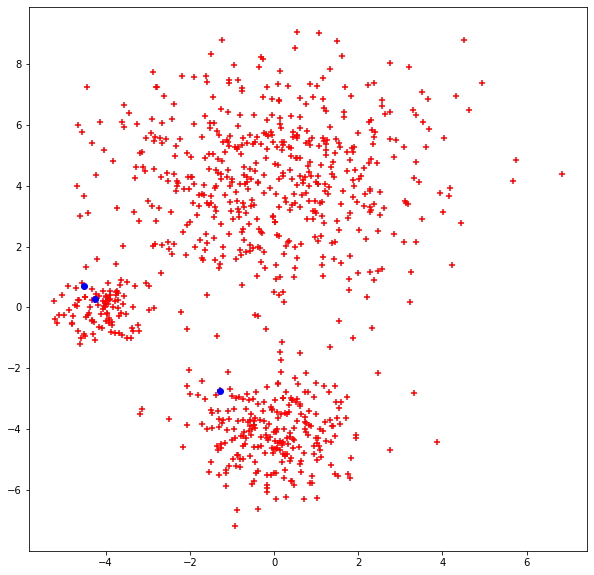

In [7]:
test_means = initialise_mean_vectors_random(Xar, 3)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(Xar[:,0], Xar[:,1], c='r', marker='+')
ax.scatter(test_means[:,0], test_means[:,1], c='b', marker='o')

# Exercise 4
Write a function that takes a sample, $\mathbf x_i \in \mathbb R^D$, a dissimilarity function (like the one you wrote above) and a set of "mean" vectors $\{\mathbf m_k\}$ and returns the index $k$ corresponding to the $\mathbf m_k$ for which dissim($\mathbf x_i$, $\mathbf m_k$) is minimised.

Test your function (i.e. does it work as expected)! We will be deploying everything written so far together next. 

In [8]:
def identify_closest_vector(x_sample, mean_vectors, dissim_fn):
  dissims = [dissim_fn(x_sample, vec) for vec in mean_vectors]
  return np.argmin(dissims)

In [9]:
x_sample = Xar[np.random.randint(Xar.shape[0]),:]
indx = identify_closest_vector(x_sample, test_means, dissim_square_euc)

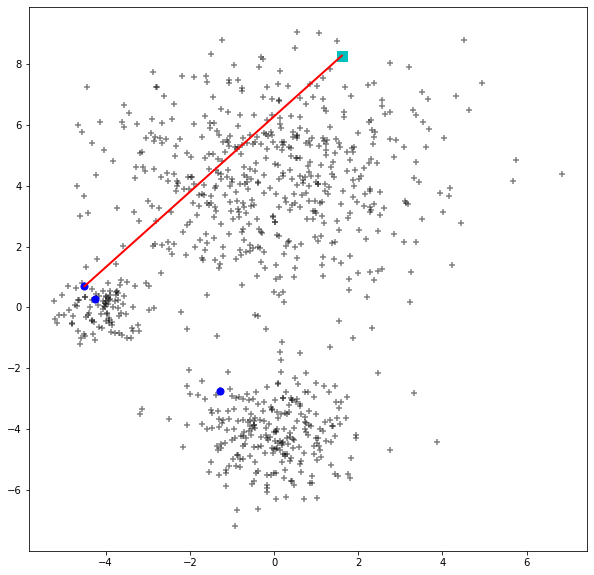

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(Xar[:,0], Xar[:,1], c='k', marker='+', alpha=0.5)
ax.scatter(test_means[:,0], test_means[:,1], c='b', marker='o', s=50)
ax.plot([x_sample[0]], [x_sample[1]], c='c', marker='s', markersize=10)
# plot x -> x_nearest_mean to verify things are working as expected
ax.plot([test_means[indx,0], x_sample[0]], [test_means[indx,1], x_sample[1]], c='r', linewidth=2)

# Exercise 5
You now have all the constituent parts to build a simple K-means clustering algorithm. Write a function that does this. It should return an array of indices of length $N$ ($N$ is number of samples) which are labels for the clusters, and an array of mean vectors representing the converged cluster centres. 

Visualise the output on your example dataset.

In [11]:
def encoder_kmeans(X_data, mean_vectors):
  """ NB we use squared Euclidean dissimiliarity by default 
      Number of clusters is defined by the shape of mean_vectors """ 

  # initial encodings of all points based on mean vectors
  n_cluster = mean_vectors.shape[0]
  encodings = np.array([identify_closest_vector(sample, mean_vectors, dissim_square_euc) 
                        for sample in X_data])

  error_in_means = 1. # initialise and error to measure difference in means between iterations

  # K means algorithm
  count = 0
  while error_in_means > 1e-10:
    old_means = np.copy(mean_vectors) # avoid just pointing to original array
    for j in range(n_cluster):
      current_data_j = X_data[encodings == j]
      current_mean_j = np.mean(current_data_j, axis=0)
      mean_vectors[j, :] = current_mean_j
    encodings = np.array([identify_closest_vector(sample, mean_vectors, dissim_square_euc) 
                          for sample in X_data])

    count += 1

    mean_diffs = mean_vectors - old_means
    error_in_means = sum(la.norm(old - new) for old, new in zip(old_means, mean_vectors))
  # print("Number clusters: ", n_cluster, "and total iterations for convergence = ", count)
  return encodings, mean_vectors

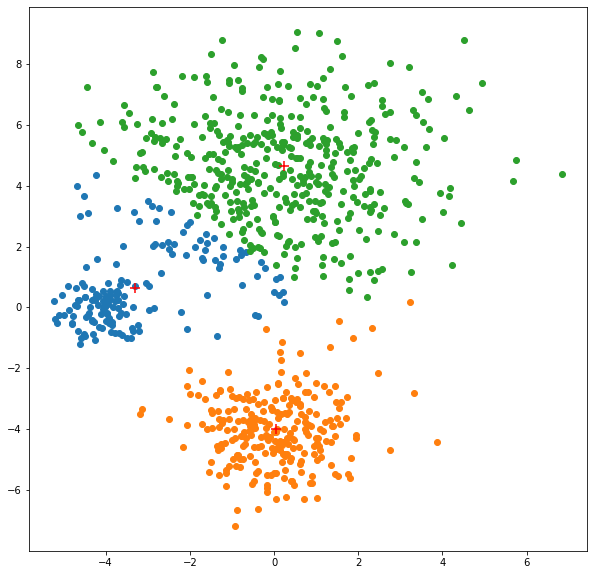

In [12]:
test_means = initialise_mean_vectors_random(Xar, 3)
encodings, mean_vecs = encoder_kmeans(Xar, test_means)

n_cluster = mean_vecs.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
for j in range(n_cluster):
  ax.scatter(Xar[encodings==j,0], Xar[encodings==j,1])
ax.scatter(mean_vecs[:,0], mean_vecs[:,1], c='r', marker='+', s=100)

Run your algorithm a few times using the "true" number of clusters (3) and visualise the results. How do the results vary between iterations? For the cases that don't "work", can you reason why? What would happen to our results if we initialised many more datapoints from "cluster 1"?

- Cases that "fail" tend to have cluster means in the first (largest standard deviation) cluster we generated -- there are lots of local minima.
- If we added more data from that distribution, we would increase the chance of picking our initial means in that cluster, which would result in many more iterations having converged cluster means in that region. 

# Exercise 6
Write a function compute the total "within cluster point scatter", $W(C)$, and compute this as a function of number of clusters, $K\in \{2, 3, 4, 5, \dots, 7\}$. Can you identify the correct number of clusters by plotting the results as described in the lecture notes? Make sure to compute $W(C)$ for a given $K$ many (try 10) times taking the best performing assignment. 

In [13]:
def within_cluster_scatter(X_data, mean_vectors, encodings):
  n_cluster = mean_vectors.shape[0]
  W_C = 0.
  for k in range(n_cluster):
    X_k = X_data[encodings == k]
    mean_k = mean_vectors[k]
    Nk = X_k.shape[0]

    sum_k = 0.
    for i in range(Nk):
      sum_k += dissim_square_euc(X_k[i], mean_k)
    W_C += Nk * sum_k
  return W_C

In [14]:
within_cluster_scatter(Xar, mean_vecs, encodings)

1453906.3729384732

In [15]:
n_clusters = np.arange(2, 8)
iterates_per_k = 10 # how many initialisations to run
W_C = []
for n in n_clusters:
  print("K = ", n)
  W_C_local = []
  for j in range(iterates_per_k):
    mean_vecs = initialise_mean_vectors_random(Xar, n)
    encodings, mean_vecs = encoder_kmeans(Xar, mean_vecs)
    W_C_local.append(within_cluster_scatter(Xar, mean_vecs, encodings))
  W_C.append(min(W_C_local))

K =  2
K =  3
K =  4
K =  5
K =  6
K =  7


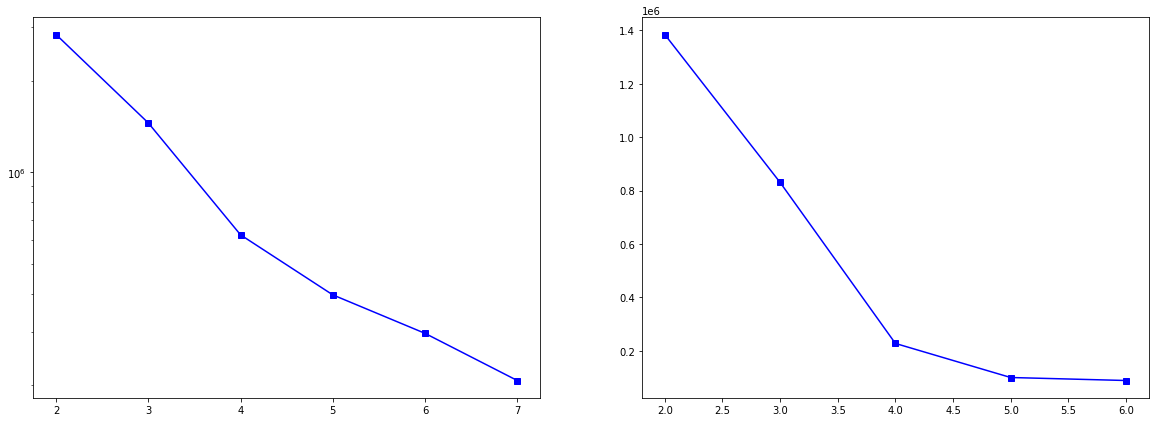

In [16]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,2,1)
ax.semilogy(n_clusters, W_C, c='b', marker='s')

ax = fig.add_subplot(1,2,2)
ax.plot(n_clusters[:-1], [W - W_p for W_p, W in zip(W_C[1:], W_C[:-1])], c='b', marker='s')

# Exercise 7
Now standardise your original dataset and re-run the K-means algorithm a few times with $K=3$. Qualitatively, how has standardising the data impacted performance? Can you argue why you observe what you see?

In [17]:
X_mean = np.mean(Xar, axis=0, keepdims=True)
X_std = np.std(Xar - X_mean, axis=0, keepdims=True)
X_normalised = (Xar - X_mean) / X_std

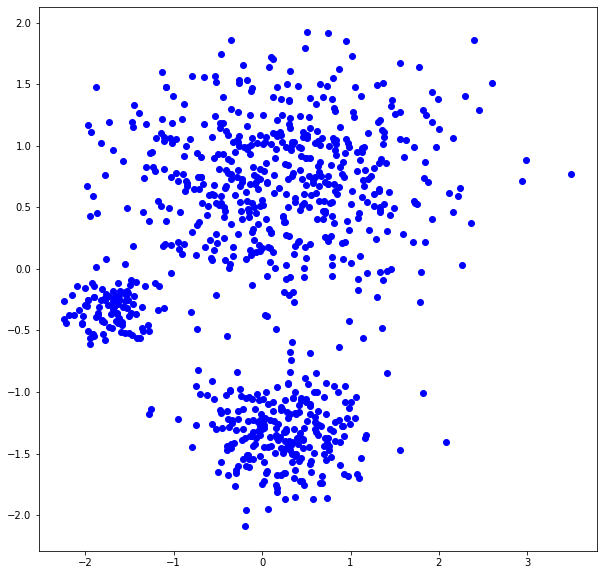

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_normalised[:,0], X_normalised[:,1], c='b', marker='o')

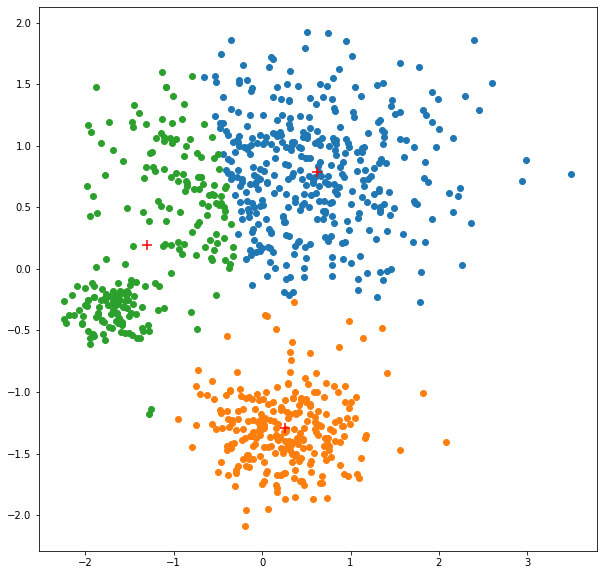

In [19]:
test_means = initialise_mean_vectors_random(X_normalised, 3)
encodings, mean_vecs = encoder_kmeans(X_normalised, test_means)

n_cluster = mean_vecs.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
for j in range(n_cluster):
  ax.scatter(X_normalised[encodings==j,0], X_normalised[encodings==j,1])
ax.scatter(mean_vecs[:,0], mean_vecs[:,1], c='r', marker='+', s=100)

In [20]:
print(np.std(Xar - X_mean, axis=0)**2)
print(np.std(X_normalised, axis=0)**2)

[ 4.40855768 16.37977512]
[1. 1.]


More of large "cluster 1" is grouped with the data from the small standard-deviation cluster after standardisation. The standardisation is equivalent to weighting features in the dissimiliarity by $1/ \text{var}_j$. Clearly identifying the smallest Gaussian cluster relies on separation in $x_2$, and the standardisation obscures this by reducing the importance of this variable by $\sim 1/4$ relative to $x_1$. 

# Exercise 8
Now we will load in a more complex dataset with a large feature space. 

The dataset is the "NCI cancer microarray dataset" discussed extensively in *Elements of Statistical Learning*.
It has been constructed from 64 samples of cancerous tisses, with 6830 "gene expressions" (the features).  Gene expression is essentially a measurement of the amount of mRNA (messenger ribonucleic acid) associated with a particular gene function. The dataset is labelled to identify the type of cancer; though our focus remains unsupervised learning and we will use the labels only to plot. 

We will need pandas to read in the data.

[*** Disclaimer: I have very limited knowledge of biology and apologise profusely for any inaccuracies above. From a mathematician's point of view: we have 6830 real valued features, don't worry about anything else ***]

In [21]:
import pandas as pd 

url_data = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.data.csv'
url_labels = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.label.txt'

data_train_X = pd.read_csv(url_data)
data_train_Y = pd.read_csv(url_labels, header=None)

# clean data and follow convention in the notes that features are columns:
data_train_X = data_train_X.drop(labels='Unnamed: 0', axis=1).T

Visualise the data (e.g. you could just do a contour plot of X, features vs samples)

Text(0, 0.5, 'Tissue sample')

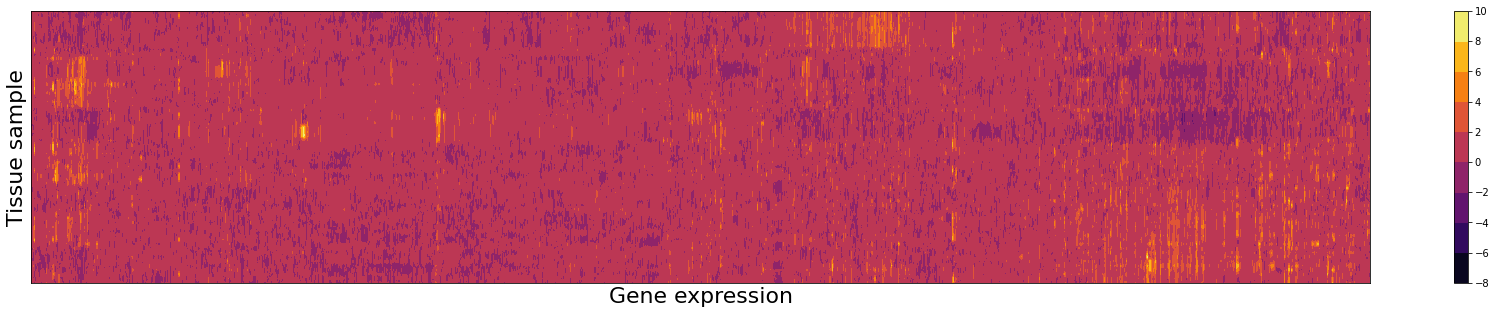

In [22]:
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(111)
contours = ax.contourf(data_train_X, cmap='inferno')#, vmax=4, vmin=-4)
cbar = plt.colorbar(contours)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Gene expression", fontsize=22)
ax.set_ylabel("Tissue sample", fontsize=22)

We now convert our pandas dataframe to a pure numpy array (feature labels are largely meaningless here).

If you visualise the labels, $Y$, you will notice there are lots of inconsistencies with white space etc. Run the following code to clean up this aspect of the dataset.

We also would like to avoid using strings to identify tissue types (largely for plotting reasons), so we give each tissue type an integer label and save the corresponding string in a dictionary.

In [23]:
X_array = np.asarray(data_train_X)
Y_array = np.asarray(data_train_Y).flatten()

for j in range(Y_array.size):
  Y_array[j] = Y_array[j].strip()

tissue_types = list(set(Y_array))
tissue_dict = {} # keep track of indices assigned to tissues for plotting 

Y_nums = np.copy(Y_array)
tissue_num = 0
for tissue_type in tissue_types:
  Y_nums[Y_array == tissue_type] = tissue_num
  tissue_dict[tissue_num] = tissue_type
  tissue_num += 1

In [24]:
tissue_dict

{0: 'LEUKEMIA',
 1: 'K562A-repro',
 2: 'COLON',
 3: 'MELANOMA',
 4: 'OVARIAN',
 5: 'NSCLC',
 6: 'MCF7A-repro',
 7: 'K562B-repro',
 8: 'UNKNOWN',
 9: 'MCF7D-repro',
 10: 'CNS',
 11: 'BREAST',
 12: 'RENAL',
 13: 'PROSTATE'}

Perform a PCA of $\mathbf X$. Think about the feature engineering you need to do upstream of this (i.e. remember to subtract the mean!). 

Could any rank truncation be justified? 

In [25]:
X_mean = np.mean(X_array, axis=0, keepdims=True)
X_array_mean_removed = X_array - X_mean

U, Sigma, V_T = la.svd(X_array_mean_removed, full_matrices=True) 

(0.001, 1.5)

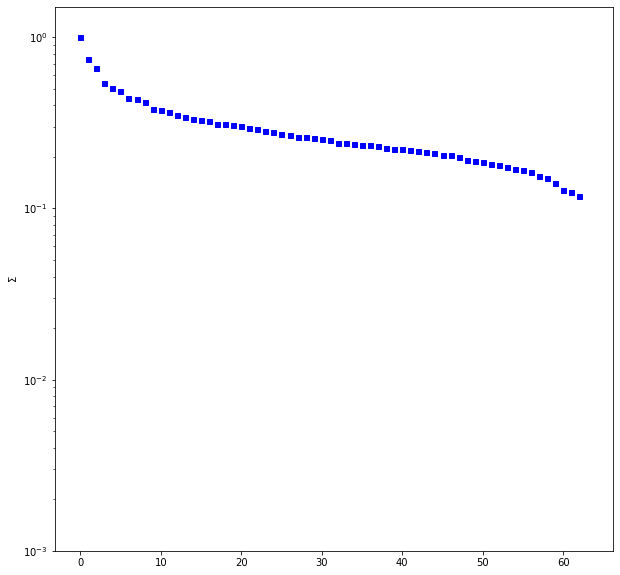

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Sigma / Sigma[0], marker='s', c='b', linestyle='none', markersize=5)
ax.set_yscale('log')
ax.set_ylabel('$\Sigma$')
ax.set_ylim(1e-3, 1.5)

Singular values decay very slowly, $\sigma_{64} \sim \sigma_1 / 10$. Dimensionality reduction unlikely to be much use.

# Exercise 9
Plot the first two principal components of the data. Plot them in two ways and verify they give the same results: by taking inner products with the appropriate columns of $\mathbf V$ and by using the matrices $\mathbf U$ and $\mathbf D$.

For plotting, we have provided some code that colours the datapoints by the associated tissue type. 

In [27]:
pca_projector_V = lambda vec, indx: V_T[indx, :].dot(vec)
pca_projector_UD_all = lambda indx: U.dot(np.diag(Sigma))[:, indx] # returns all results

In [28]:
pca_mode_1 = 0
pca_mode_2 = 1

# we will project directly onto the modes, then verify that they are recorved in UD too 
proj_mode_1 = []
proj_mode_2 = []

for row in X_array_mean_removed:
  proj_mode_1.append(pca_projector_V(row, pca_mode_1))
  proj_mode_2.append(pca_projector_V(row, pca_mode_2))

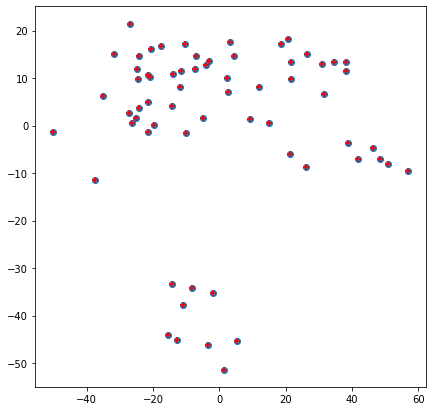

In [29]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_mode_1, proj_mode_2)
ax.scatter(pca_projector_UD_all(pca_mode_1), pca_projector_UD_all(pca_mode_2), c='r', marker='+')

Here is code to colour by tissue type, assuming you have stored the principal components in two lists, proj_mode_1 and proj_mode_2

In [30]:
import matplotlib.colors as mcolors
import random

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
color_list = [key for key in colors]
random.shuffle(color_list)
color_map = {}

for tissue, color in zip(tissue_types, color_list):
  color_map[tissue] = color

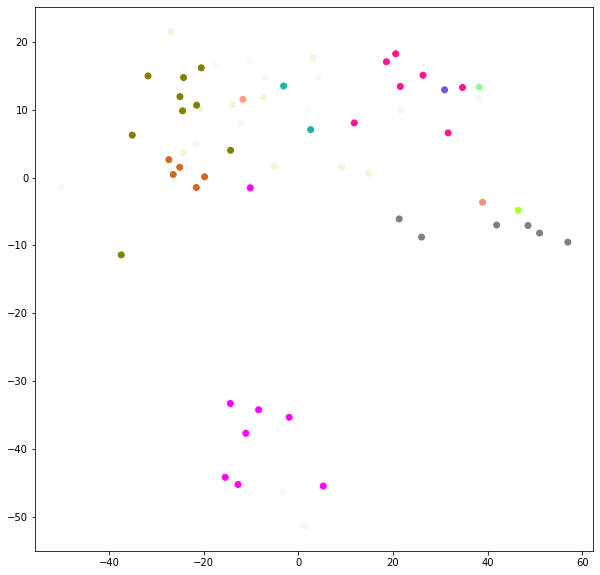

In [31]:
colors_true = [color_map[label] for label in Y_array]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_mode_1, proj_mode_2, c=colors_true)

# Exercise 10
Perform K-means clustering on the gene expressions. If you followed the exercises above this should be implementable in a few lines. 

Plot the total within-cluster scatter as a function of cluster number. Is there a natural number of clusters? How do your clusters appear when the data is plotted projected onto principal components? Make sure to initialise a large number of starting vectors to search for the best $W(C)$.  

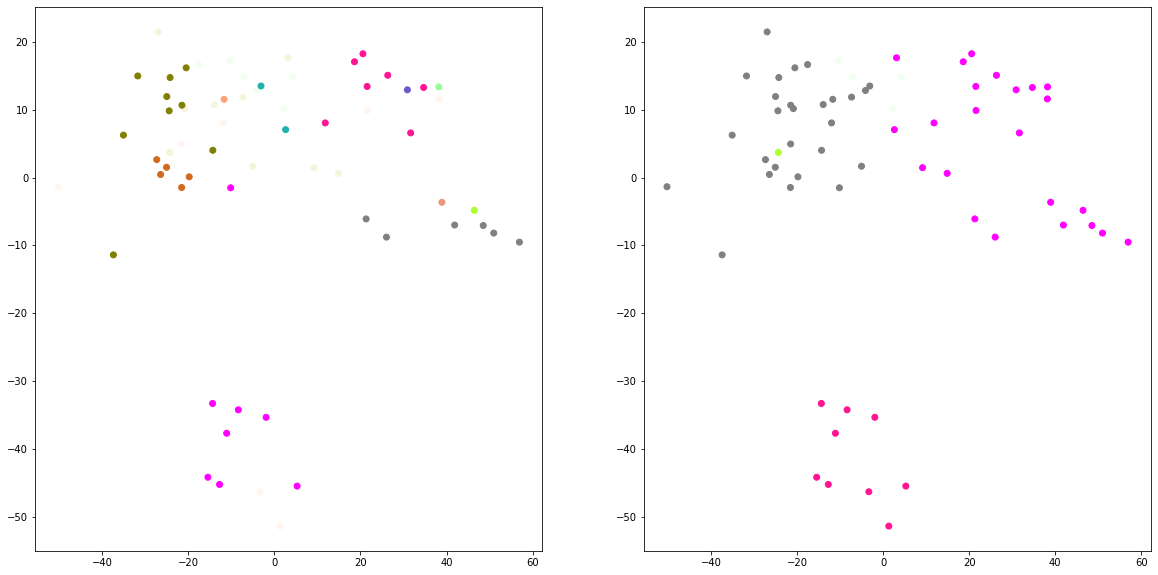

In [32]:
gene_means = initialise_mean_vectors_random(X_array, 5)
encodings, mean_vecs = encoder_kmeans(X_array, gene_means)
n_cluster = mean_vecs.shape[0]

colors_k = [color_map[tissue_types[label]] for label in encodings]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(proj_mode_1, proj_mode_2, c=colors_true)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(proj_mode_1, proj_mode_2, c=colors_k)

Results visualised in terms of principal components are somewhat challenging to interpret, and we can see that the true data has many cancer types which appear closely grouped in this projection. 

We will attempt to identify the "optimal" number of clusters and then revisit.

In [33]:
n_clusters = np.arange(2, 11)
iterates_per_k = 64 # how many initialisations to run
W_C = []
for n in n_clusters:
  print("K = ", n)
  W_C_local = []
  for j in range(iterates_per_k):
    mean_vecs = initialise_mean_vectors_random(X_array, n)
    encodings, mean_vecs = encoder_kmeans(X_array, mean_vecs)
    W_C_local.append(within_cluster_scatter(X_array, mean_vecs, encodings))
  W_C.append(min(W_C_local))

K =  2
K =  3
K =  4
K =  5
K =  6
K =  7
K =  8
K =  9
K =  10


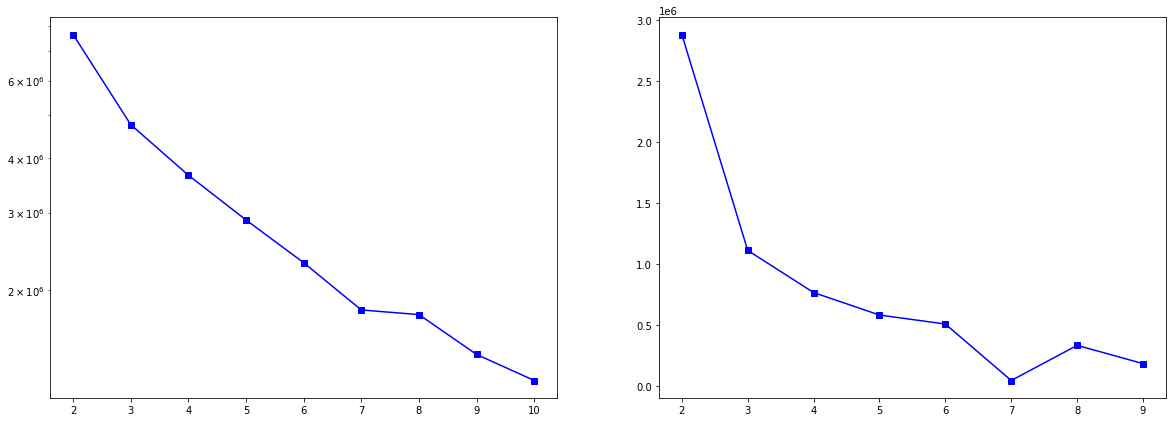

In [34]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,2,1)
ax.semilogy(n_clusters, W_C, c='b', marker='s')

ax = fig.add_subplot(1,2,2)
ax.plot(n_clusters[:-1], [W - W_p for W_p, W in zip(W_C[1:], W_C[:-1])], c='b', marker='s')

Optimal value appears to be around 5, but this is hardly rigorous! 

# Exercise 11
As a final exercise, we will construct a dendogram for the gene expression dataset. We will use the "linkage" function from within the scipy.cluster library. 

In contrast to our K-means approach, we will not implement this from scratch! 

Have a look at the implementation 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

Plot a dendogram (hierarchy.dendogram( ... )) for the gene expression dataset and explore the effect of different cluster dissimilarity measures discussed in the lecture (which can be selected with the "method" argument in the linkage function. 

In [36]:
from scipy.cluster import hierarchy
 
# linkages 
method = 'single'
link_mat = hierarchy.linkage(X_array, method)

In [37]:
link_mat.shape # 63 rows because ... N - 1 levels
# link_mat

(63, 4)

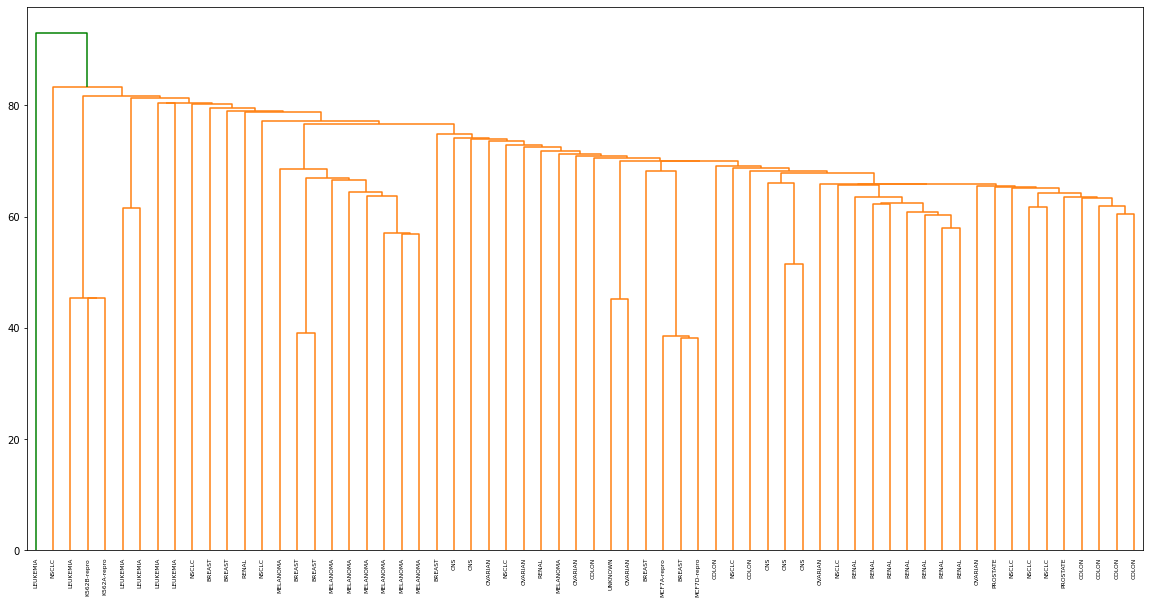

In [38]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,1,1) 
dn = hierarchy.dendrogram(
    link_mat, color_threshold=90, above_threshold_color="green", count_sort='ascending', labels=Y_array)
# ax.set_ylim(30, None)
# ax.set_yscale('log') 

Group verage / complete linkage show relatively similar results with similar tissue types grouped. Single linkage features lots of single points being added to clusters -- could be evidence of chaining phenomenon.